In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [ ]:
import warnings
warnings.filterwarnings("error")

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
class ActorCritic(tf.keras.Model):
    def __init__(self, mode):
        super().__init__()
        
        assert mode == 'actor' or mode == 'critic'
        
        self.mode = mode
        
        self.main = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), bias_initializer="ones", 
                          filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=16, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=5, padding="same", 
                          activation="sigmoid" if mode == "actor" else None),
            layers.Reshape((BOARD_SIZE, BOARD_SIZE))
        ])
             
        self.pass_decision = tf.keras.Sequential([
            layers.Conv2D(input_shape=(BOARD_SIZE, BOARD_SIZE, 4), 
                          filters=16, kernel_size=3, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=5, padding="same"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=64, kernel_size=BOARD_SIZE, padding="valid"),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(filters=1, kernel_size=1, padding="valid", 
                          activation="sigmoid" if mode == 'actor' else None),
            layers.Reshape((1,)),
        ])
    def call(self, inputs):
        action_distr = self.main(inputs)
            
        # Mask out invalid moves
        action_distr = (1-inputs[:,:,:,2]) * action_distr
        
        pass_decision = self.pass_decision(inputs)
        return action_distr, pass_decision

In [9]:
actor = ActorCritic(mode='actor')

In [10]:
actor.load_weights('tmp/actor.h5')

OSError: Unable to open file (unable to open file: name = 'tmp/actor.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [11]:
critic = ActorCritic(mode='critic')

In [ ]:
critic.load_weights('tmp/critic.h5')

In [12]:
import os
def copy_actor_critic(model, mode):
    if not os.path.exists('tmp'):
        os.mkdir('tmp/')
        
    model.save_weights('tmp/tmp_model.h5')
    clone = ActorCritic(mode=mode)
    clone.load_weights('tmp/tmp_model.h5')
    return clone

In [13]:
opponent = copy_actor_critic(actor, 'actor')
target_critic = copy_actor_critic(critic, 'critic')

In [14]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [15]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[[0,1,3]].transpose(1,2,0).astype(np.float), state[2]] if not channels_last else 
                                          [state[:,:,[0,1,3]].astype(np.float), state[:,:,2]], 
                                          ['board', 'invalid'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

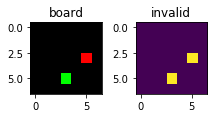

In [16]:
plot_state(state, channels_last=False)

In [17]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

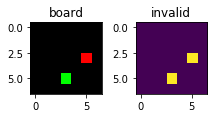

In [18]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [19]:
board_probs, pass_decision = actor(state.astype(np.float32))

In [20]:
board_vals, pass_vals = critic(state.astype(np.float32))

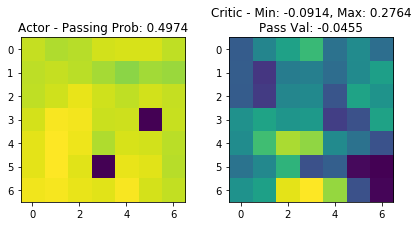

In [21]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {:.4f}'.format(pass_decision[0][0]))
plt.imshow(board_probs[0])
plt.subplot(1,2,2)
plt.title('Critic - Min: {:.4f}, Max: {:.4f}\nPass Val: {:.4f}'.
          format(tf.math.reduce_min(board_vals[0]), 
                 tf.math.reduce_max(board_vals[0]), 
                 pass_vals[0][0]))
plt.imshow(board_vals[0])
plt.tight_layout()

# Training Setup

### Hyperparameters

In [22]:
NUM_EPISODES = 100
BATCH_SIZE = 64
REPLAY_MEM_SIZE = 3e3
OPPONENT_UPDATE = 1e9 # NEVER UPDATE OPPONENT FOR NOW
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.1
GAMMA = 0.95
TARGET_UPDATE = 1 # number of episodes to update the target critic model

In [23]:
from collections import deque

In [24]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [25]:
actor_metrics = {}
for metric_key in ['loss']:
    actor_metrics[metric_key] = tf.keras.metrics.Mean('actor_{}'.format(metric_key), dtype=tf.float32)

critic_metrics = {}
for metric_key in ['loss']:
    critic_metrics[metric_key] = tf.keras.metrics.Mean('critic_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [26]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['main']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

### Functions

In [27]:
from sklearn import preprocessing
def random_weighted_action(state, pass_prob, board_weights):
    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.isnan(board_weights).any() or np.sum(board_weights) <= 0:
        action = None
    else:
        board_weights_sum = np.sum(board_weights)
        board_weights = tf.reshape(board_weights, (1,BOARD_SIZE**2))
        board_weights = preprocessing.normalize(board_weights, norm='l1')
        board_weights = board_weights.reshape((BOARD_SIZE**2,))
        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=board_weights)
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [28]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        board_weights = 1 - state[2]
        board_weights = board_weights / np.sum(board_weights)
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=board_weights)
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        if state.shape[0] == 4:
            state = state.transpose(1,2,0)
        act_prob_distr, pass_decision = policy(state
                                               .reshape(1, BOARD_SIZE, BOARD_SIZE, 4)
                                               .astype(np.float32))
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [29]:
def get_value_for_action(board_values, passing_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(board_values, [(i, a[0], a[1]) if a is not None 
                                                    else (i, 0, 0) 
                                                    for i, a in enumerate(actions)])
    action_values = tf.where([a is not None for a in actions], action_values, passing_values)
    return action_values

In [30]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,3,2,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,3,2,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    return orig_states, actions, states, rewards, terminals
    

In [31]:
def calculate_state_vals(states, policy, actval_func):
    '''
    Get the expected value of states
    '''
    board_prob_distrs, passing_probs = policy(states)
    board_val_distrs, passing_vals = actval_func(states)
    
    passing_probs = tf.reshape(passing_probs, (-1,))
    passing_vals = tf.reshape(passing_vals, (-1,))
    
    # state value is the expected critic value based on the actor's policy
    state_vals = tf.reduce_sum(board_prob_distrs * board_val_distrs, axis=[1,2])
    state_vals = passing_probs * passing_vals + (1 - passing_probs) * state_vals
    return state_vals

In [32]:
critic_optimizer = tf.keras.optimizers.Adam(1e-5)
def update_critic():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals  = get_batch_obs()
    
    # get expected values for next state
    next_state_vals = calculate_state_vals(next_states, actor, target_critic)
    
    with tf.GradientTape() as tape:
        board_val_distrs, passing_vals = critic(states)
        passing_vals = tf.reshape(passing_vals, (-1,))
        action_vals = get_value_for_action(board_val_distrs, passing_vals, actions)
        val_loss = mse(rewards + GAMMA * next_state_vals * (1-terminals), action_vals)
    
    critic_metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients, critic.trainable_variables))

In [33]:
actor_optimizer = tf.keras.optimizers.Adam(1e-5)
def update_actor():
    """
    Optimizes the actor in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals = get_batch_obs()
    
    # State values
    state_vals = calculate_state_vals(states, actor, critic)
    
    # Next state values
    next_state_vals = calculate_state_vals(next_states, actor, critic)
    
    # Advantage values
    avntg_vals = (rewards + GAMMA * next_state_vals * (1-terminals)) - state_vals
    
    with tf.GradientTape() as tape:
        board_prob_distrs, passing_probs = actor(states)
        passing_probs = tf.reshape(passing_probs, (-1,))
        action_probs = get_value_for_action(board_prob_distrs, passing_probs, actions)
        avntg_loss = - tf.math.log(action_probs + 1e-6) * avntg_vals
        avntg_loss = tf.math.reduce_mean(avntg_loss)
    
    # log the loss in tensorboard
    actor_metrics['loss'](avntg_loss)
        
    # compute and apply gradients
    gradients = tape.gradient(avntg_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(gradients, actor.trainable_variables))

In [34]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    max_steps = BOARD_SIZE**3
    rewards = []
    
    while not done and num_of_turns <= max_steps:
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        # Update the critic and then actor if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_critic()        
            update_actor()
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, epsilon=0)
        if action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

# Train

In [35]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [36]:
%tensorboard --logdir logs/actor_critic

Reusing TensorBoard on port 6007 (pid 38920), started 12:53:56 ago. (Use '!kill 38920' to kill it.)

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


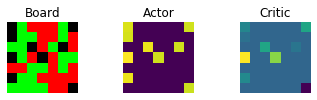

  1%|          | 1/100 [00:01<03:02,  1.85s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


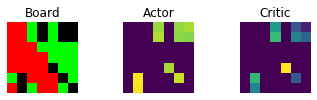

  2%|▏         | 2/100 [00:22<12:01,  7.36s/it]

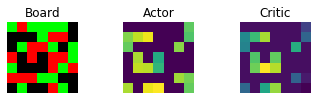

  3%|▎         | 3/100 [00:29<12:07,  7.50s/it]

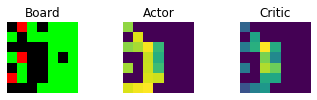

  4%|▍         | 4/100 [00:32<09:31,  5.95s/it]

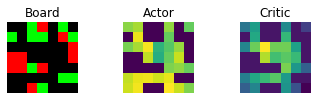

  5%|▌         | 5/100 [00:34<07:49,  4.94s/it]

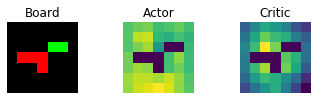

  6%|▌         | 6/100 [00:39<07:40,  4.89s/it]

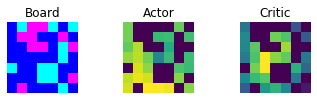

  7%|▋         | 7/100 [00:43<07:20,  4.73s/it]

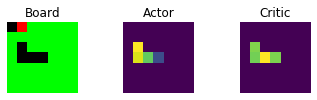

  8%|▊         | 8/100 [00:52<08:58,  5.86s/it]

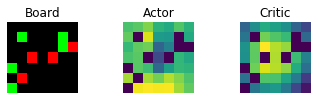

  9%|▉         | 9/100 [00:53<06:51,  4.52s/it]

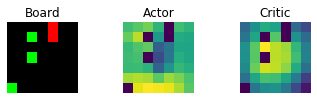

 10%|█         | 10/100 [00:55<05:22,  3.58s/it]

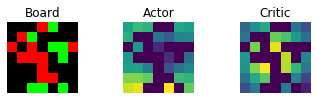

 11%|█         | 11/100 [01:03<07:24,  4.99s/it]

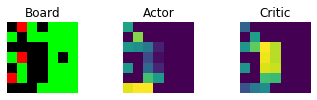

 12%|█▏        | 12/100 [01:05<05:52,  4.01s/it]

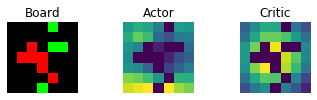

 13%|█▎        | 13/100 [01:06<04:30,  3.11s/it]

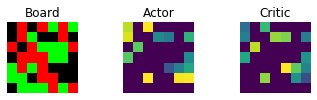

 14%|█▍        | 14/100 [01:07<03:33,  2.48s/it]

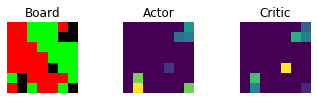

 15%|█▌        | 15/100 [01:07<02:46,  1.96s/it]

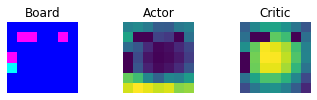

 16%|█▌        | 16/100 [01:12<03:49,  2.74s/it]

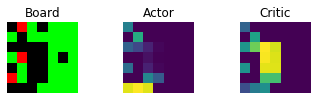

 17%|█▋        | 17/100 [01:13<03:04,  2.22s/it]

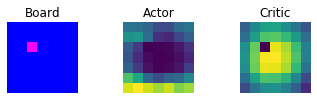

 18%|█▊        | 18/100 [01:16<03:07,  2.29s/it]

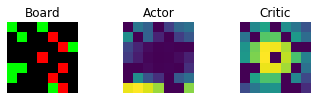

 19%|█▉        | 19/100 [01:18<03:04,  2.28s/it]

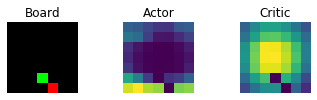

 20%|██        | 20/100 [01:21<03:17,  2.47s/it]

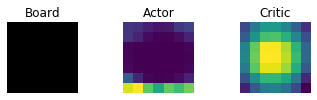

 21%|██        | 21/100 [01:31<06:24,  4.86s/it]

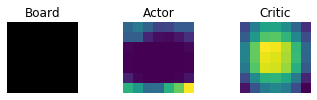

 22%|██▏       | 22/100 [01:48<10:49,  8.33s/it]

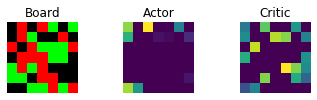

 23%|██▎       | 23/100 [01:57<11:11,  8.72s/it]

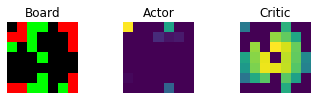

 24%|██▍       | 24/100 [02:08<12:01,  9.49s/it]

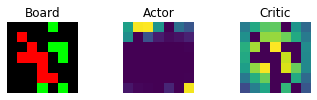

 25%|██▌       | 25/100 [02:21<13:11, 10.55s/it]

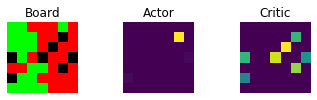

 26%|██▌       | 26/100 [02:33<13:14, 10.73s/it]

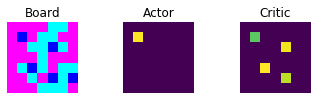

 27%|██▋       | 27/100 [02:43<12:49, 10.54s/it]

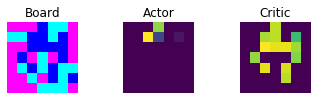

 28%|██▊       | 28/100 [02:53<12:31, 10.44s/it]

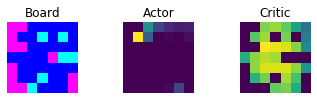

 29%|██▉       | 29/100 [03:04<12:37, 10.67s/it]

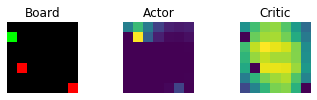

 30%|███       | 30/100 [03:14<12:10, 10.44s/it]

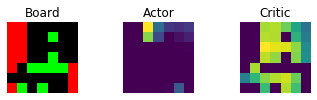

 31%|███       | 31/100 [03:25<12:05, 10.51s/it]

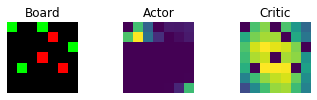

 32%|███▏      | 32/100 [03:35<11:42, 10.32s/it]

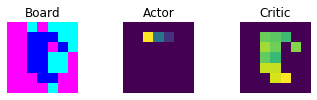

 33%|███▎      | 33/100 [03:51<13:40, 12.24s/it]

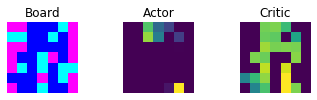

 34%|███▍      | 34/100 [04:04<13:38, 12.40s/it]

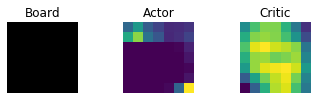

 35%|███▌      | 35/100 [04:21<14:47, 13.65s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


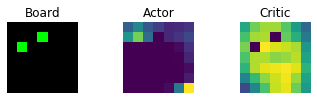

 36%|███▌      | 36/100 [04:32<13:43, 12.87s/it]

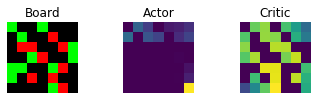

 37%|███▋      | 37/100 [04:46<14:03, 13.39s/it]

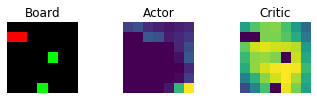

 38%|███▊      | 38/100 [05:06<15:39, 15.16s/it]

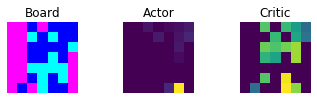

 39%|███▉      | 39/100 [05:16<13:58, 13.75s/it]

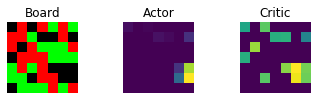

 40%|████      | 40/100 [05:48<19:15, 19.25s/it]

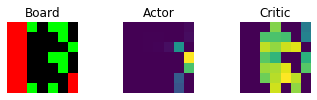

 41%|████      | 41/100 [06:07<18:52, 19.20s/it]

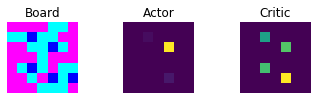

 42%|████▏     | 42/100 [06:19<16:29, 17.06s/it]

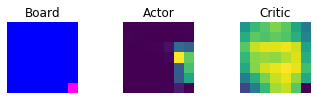

 43%|████▎     | 43/100 [06:36<16:02, 16.89s/it]

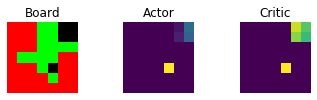

 44%|████▍     | 44/100 [06:55<16:21, 17.53s/it]

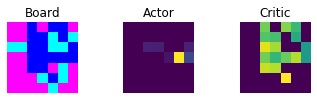

 45%|████▌     | 45/100 [07:18<17:29, 19.08s/it]

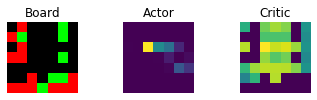

 46%|████▌     | 46/100 [08:08<25:39, 28.50s/it]

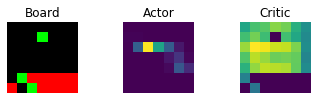

 47%|████▋     | 47/100 [08:22<21:24, 24.24s/it]

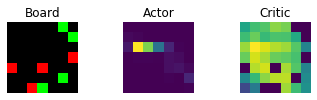

 48%|████▊     | 48/100 [09:11<27:18, 31.51s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


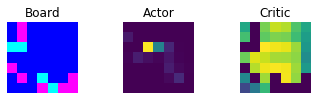

 49%|████▉     | 49/100 [09:36<25:09, 29.59s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


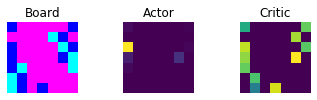

 50%|█████     | 50/100 [10:19<28:09, 33.79s/it]

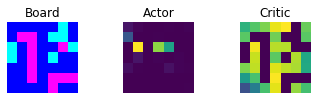

 51%|█████     | 51/100 [10:46<25:45, 31.53s/it]

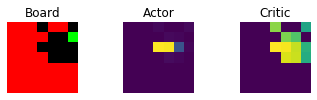

 52%|█████▏    | 52/100 [11:10<23:30, 29.39s/it]

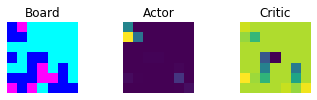

 53%|█████▎    | 53/100 [11:28<20:19, 25.94s/it]

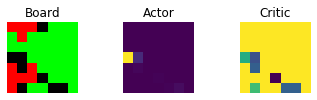

 54%|█████▍    | 54/100 [11:53<19:38, 25.61s/it]

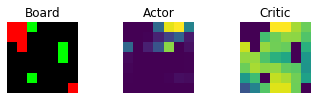

 55%|█████▌    | 55/100 [12:08<16:50, 22.46s/it]

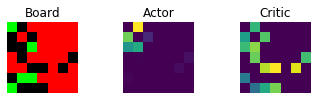

 56%|█████▌    | 56/100 [12:18<13:42, 18.69s/it]

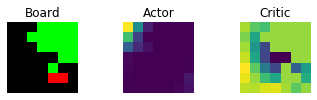

 57%|█████▋    | 57/100 [12:26<11:07, 15.53s/it]

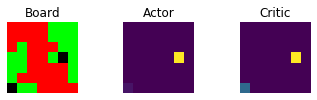

 58%|█████▊    | 58/100 [12:45<11:31, 16.47s/it]

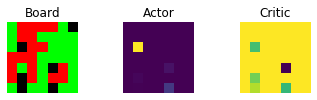

 59%|█████▉    | 59/100 [13:07<12:26, 18.20s/it]

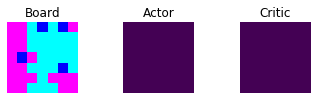

 60%|██████    | 60/100 [13:41<15:22, 23.07s/it]

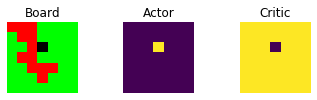

 61%|██████    | 61/100 [14:03<14:38, 22.53s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


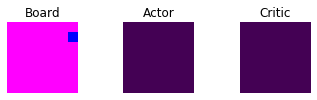

 62%|██████▏   | 62/100 [14:16<12:37, 19.92s/it]

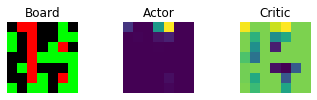

 63%|██████▎   | 63/100 [14:47<14:19, 23.23s/it]

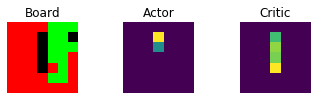

 64%|██████▍   | 64/100 [15:13<14:23, 23.97s/it]

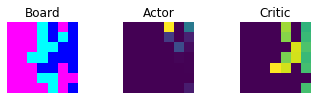

 65%|██████▌   | 65/100 [15:34<13:29, 23.14s/it]

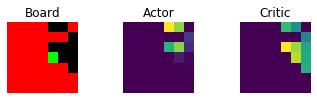

 66%|██████▌   | 66/100 [15:50<11:52, 20.96s/it]

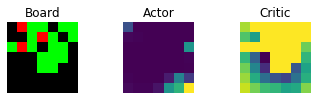

 67%|██████▋   | 67/100 [16:22<13:23, 24.35s/it]

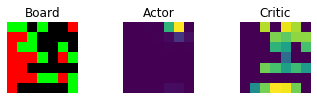

 68%|██████▊   | 68/100 [17:11<16:53, 31.66s/it]

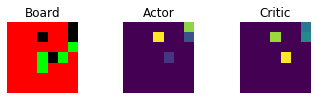

 69%|██████▉   | 69/100 [17:48<17:09, 33.19s/it]

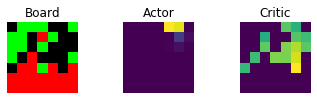

 70%|███████   | 70/100 [18:37<18:54, 37.83s/it]

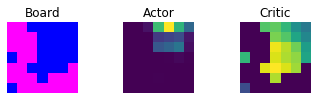

 71%|███████   | 71/100 [19:19<18:56, 39.20s/it]

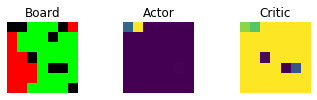

 72%|███████▏  | 72/100 [19:37<15:18, 32.81s/it]

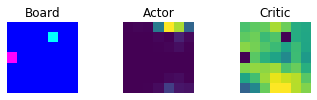

 73%|███████▎  | 73/100 [19:48<11:46, 26.16s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


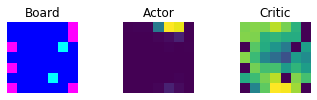

 74%|███████▍  | 74/100 [20:01<09:41, 22.35s/it]

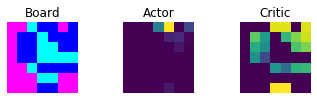

 75%|███████▌  | 75/100 [20:27<09:47, 23.51s/it]

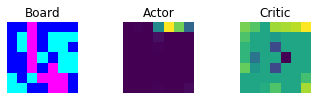

 76%|███████▌  | 76/100 [20:43<08:29, 21.25s/it]

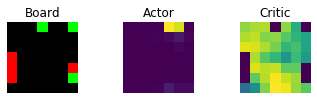

 77%|███████▋  | 77/100 [20:47<06:06, 15.92s/it]

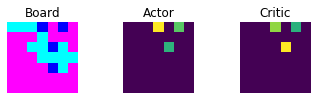

 78%|███████▊  | 78/100 [21:02<05:45, 15.71s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


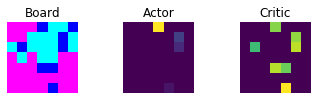

 79%|███████▉  | 79/100 [21:24<06:12, 17.73s/it]

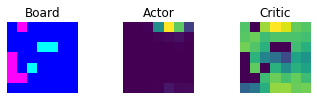

 80%|████████  | 80/100 [21:35<05:10, 15.54s/it]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


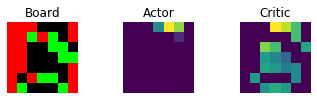

 81%|████████  | 81/100 [21:57<05:35, 17.64s/it]

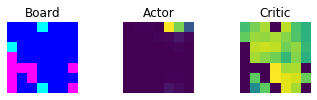

 82%|████████▏ | 82/100 [22:08<04:41, 15.63s/it]

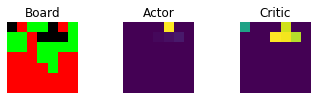

 83%|████████▎ | 83/100 [22:29<04:52, 17.19s/it]

In [ ]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in actor_metrics.values():
        metric.reset_states()
    for metric in critic_metrics.values():
        metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        opponent = copy_actor_critic(actor, 'actor')
        
    if episode % TARGET_UPDATE == 0:
        target_critic = copy_actor_critic(critic, 'critic')

    num_turns, rewards = train(episode)
    
    # Plot samples of states and actor, critic heatmaps
    num_samples = 1
    states, _, _, _,_ = get_batch_obs(num_samples)
    board_prob_distrs, pass_probs = actor(states)
    board_val_distrs, pass_vals = critic(states)
    plt.figure(figsize=(5,1.5))
    for i in range(num_samples):
        plt.subplot(num_samples,3,3*i+1+0)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))
        plt.subplot(num_samples,3,3*i+1+1)
        plt.axis('off')
        plt.title('Actor')
        plt.ylabel('Pass Prob: {:.4f}'.format(pass_probs[i][0]))
        plt.imshow(board_prob_distrs[i])
        plt.subplot(num_samples,3,3*i+1+2)
        plt.axis('off')
        plt.title('Critic')
        plt.ylabel('Max Board Val {:.4f}\nPass Val: {:.4f}'
                  .format(np.max(board_val_distrs), pass_vals[i][0]))
        plt.imshow(board_val_distrs[i])
        
    plt.tight_layout()
    plt.show()
    
    # log results
    with summary_writers['main'].as_default():
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('rewards sum', sum(rewards), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('critic loss', critic_metrics['loss'].result(), step=episode)
        tf.summary.scalar('actor loss', actor_metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

In [ ]:
actor.save_weights('tmp/actor.h5')
critic.save_weights('tmp/critic.h5')

# Evaluate

Test against a pretrained AI

In [ ]:
# TODO

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, 0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)